### Necessary Libraries

In [50]:
import numpy as np
import skimage
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
import time
import math
import cv2

### Loading all images

In [51]:
# Please Change the image addresses accordingly

coins = np.array(skimage.io.imread('/content/coins.png'))
charachters = np.array(skimage.io.imread('/content/Characters.png'))
IIScMainBuilding =  np.array(skimage.io.imread('/content/IIScMainBuilding.png'))
IIScText =  np.array(skimage.io.imread('/content/IIScText.png'))
IIScTextDepth =  np.array(skimage.io.imread('/content/IIScTextDepth.png'))
quote =  np.array(skimage.io.imread('/content/quote.png'))

### **1. Histogram Computation:**
Compute the histogram of the image `coins.png`, by finding the frequency of pixels for each intensity level {0, 1, . . . , 255}. Show the histogram by plotting frequencies w.r.t. intensity levels. Comment on what you observe. Also, find the average intensity of the image using this histogram. Verify the result with the actual average intensity.

---

|Function | Histogram |
|---------|-----------|
|Input    | Grayscale image |
|Output   |Frequencies at each intensity level (( a list / vector of size 256 ))


In [52]:
#plt.imshow(coins,cmap = 'gray')

In [53]:
# Main Histogram Function

def histogram(A):

  histogram = np.zeros(256,dtype = 'int')

  for i in A.ravel():
      histogram[i]+=1

  return histogram

In [54]:
# Demo Code
time_initial = time.time()
hist_img = histogram(coins)
time_req = time.time() - time_initial

avg_int = 1
for i in range(len(hist_img)):
  avg_int+=(hist_img[i]*i)
avg_int/= sum(hist_img)

# Code for Lib Function
hist_lib = np.histogram(coins.ravel(),bins = range(257))[0]

avg_int_lib = 1
for i in range(len(hist_lib)):
  avg_int_lib+=(hist_lib[i]*i)
avg_int_lib/= sum(hist_lib)

print('Time required for computation fo histogram is '+str(round(time_req,5))+'s')
print('The average intensity of Image is ' + str(round(avg_int,3)))
print('The average intensity of Image given by Lib Function is ' + str(round(avg_int_lib,3)))

Time required for computation fo histogram is 0.02014s
The average intensity of Image is 103.305
The average intensity of Image given by Lib Function is 103.305


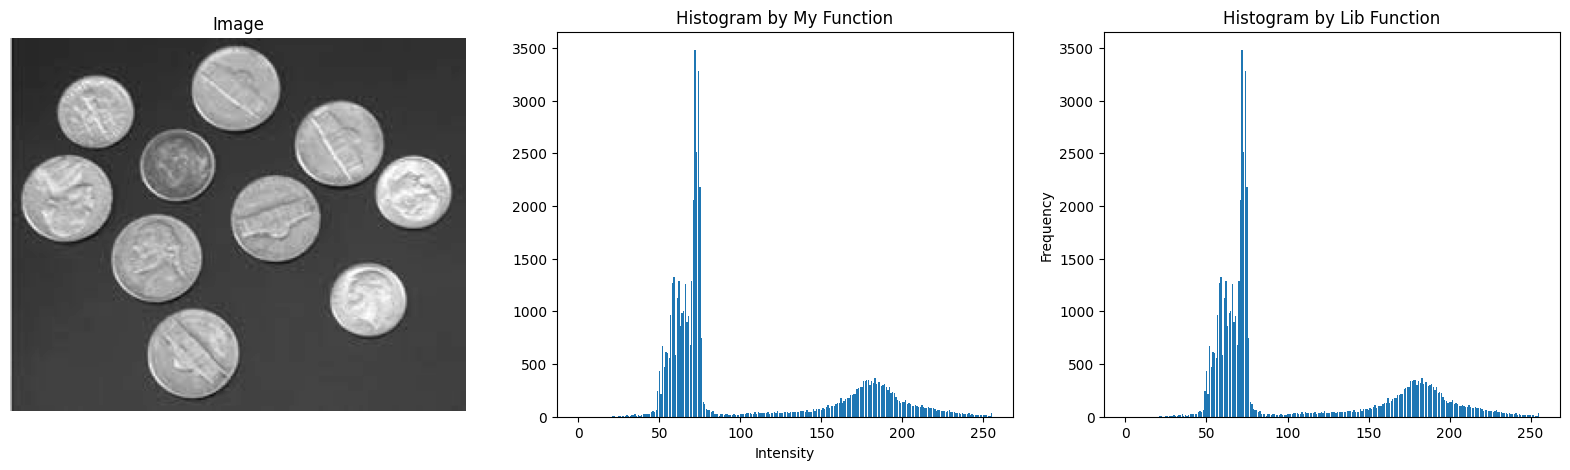

In [55]:
# Comparison

fig, axes = plt.subplots(ncols=3, figsize=(20,5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3)

ax[0].imshow(coins, cmap=plt.cm.gray)
ax[0].set_title('Image')
ax[0].axis('off')

ax[1].bar(range(256),histogram(coins))
ax[1].set_title('Histogram by My Function')
ax[1].set_xlabel('Intensity')
ax[2].set_ylabel('Frequency')

ax[2].bar(range(256),np.histogram(coins.ravel(),bins = range(257))[0])
ax[2].set_title('Histogram by Lib Function')
ax[1].set_xlabel('Intensity')
ax[2].set_ylabel('Frequency')


plt.show()

### **2. Otsu's Binarization:**

In the class, we showed that, $ 𝜎^{2}_{𝜔}(t)+𝜎^{2}_{b}(t)= 𝜎^{2}_{T}(t) $ ,
where **t** is the threshold for binarization. Compute the threshold t for the image `coins.png` by:

(a) Minimizing the within class variance $𝜎^{2}_{𝜔}$.

(b) Maximizing the between class variance $𝜎^{2}_{b}$

##### Verify that both methods are equivalent. Compare the time taken by each of the approach
---

|Function| *Within Class Variance*    | *Between Class Variance*    |
|--------|----------------------------|-----------------------------|
|Input   |Grayscale image , threshold | Grayscale image , threshold |
|Output  | Within Class Variance      | Between Class Variance      |

#### Within_Class_Variance Function


In [56]:
def within_class_variance(Image,t):

  hist = histogram(Image)    #image histogram

  # Probability Mass Function p(intensity)

  p = hist/(len(Image)*len(Image[0]))                                           # probability that a pixel value takes a certain intensity

  # Class Probabilities

  w0 = 0                                                                        # probability that a pixel belongs to class 0 in a binary image
  for k in range(t+1):
    w0+=p[k]

  w1 = 0                                                                        # probability that a pixel belongs to class 0 in a binary image
  for k in range(t+1,256):
    w1+=p[k]

  #print(w0)

  if w0!=0 and w1!=0:

    # Class Means

    mu0 = 0                                                                     # mean of a pixel belonging to class 0 in a binary image
    for k in range(t+1):
      mu0+= k*p[k]
    mu0*=(1/w0)

    mu1 = 0                                                                     # mean of a pixel belonging to class 1 in a binary image
    for k in range(t+1,256):
      mu1+= k*p[k]
    mu1*=(1/w1)

    muT =  mu0*w0+ mu1*w1                                                       # overall image mean

    # Class Variances

    sigma0_square = 0                                                           # Class Variance of class 0
    for k in range(t+1):
      sigma0_square+= (k-mu0)**2 * p[k]
    sigma0_square*=(1/w0)

    sigma1_square = 0                                                           # Class Variance of class 1
    for k in range(t+1,256):
      sigma1_square+= (k-mu1)**2 * p[k]
    sigma1_square*=(1/w1)

    intra_class_variance = (sigma0_square*w0) + (sigma1_square*w1)

  else:
    intra_class_variance = 2**32

  return intra_class_variance

#### Between_Class_Variance Function

In [57]:
def between_class_variance(Image,t):

  hist = histogram(Image)    #image histogram

  # Probability Mass Function p(intensity)

  p = hist/(len(Image)*len(Image[0]))         #probability that a pixel value takes a certain intensity

  # Class Probabilities

  w0 = 0                      #probability that a pixel belongs to class 0 in a binary image
  for k in range(t+1):
    w0+=p[k]

  w1 = 0                      #probability that a pixel belongs to class 0 in a binary image
  for k in range(t+1,256):
    w1+=p[k]

  #print(w0)

  if w0!=0 and w1!=0:

    # Class Means

    mu0 = 0                    #mean of a pixel belonging to class 0 in a binary image
    for k in range(t+1):
      mu0+= k*p[k]
    mu0*=(1/w0)

    mu1 = 0                    #mean of a pixel belonging to class 1 in a binary image
    for k in range(t+1,256):
      mu1+= k*p[k]
    mu1*=(1/w1)

    muT =  mu0*w0+ mu1*w1      #overall image mean

    inter_class_variance = w0 * w1 * (mu0 - mu1)**2

  else:
    inter_class_variance = 0

  return inter_class_variance

#### Finding Threshold

In [58]:
# Demo Code #1

time_initial = time.time()
within_class_variance_array = []
for t in range(256):
    within_class_variance_array.append(within_class_variance(coins,t))

t_within_class  = np.argmin(within_class_variance_array)

time_taken = time.time() - time_initial

print('Time taken for optimimzing within class variance is '+str(round(time_taken,3))+'s')
print('The optimal threshold value is ' + str(t_within_class))
print('The minimum value of within class variance is ' + str(round(within_class_variance_array[t_within_class],3)))

Time taken for optimimzing within class variance is 5.983s
The optimal threshold value is 125
The minimum value of within class variance is 265.102


In [59]:
# Demo Code #2

time_initial = time.time()
between_class_variance_array = []
for t in range(256):
    between_class_variance_array.append(between_class_variance(coins,t))

t_between_class  = np.argmax(between_class_variance_array)

time_taken = time.time() - time_initial

print('Time taken for optimimzing between class variance is '+str(round(time_taken,3))+'s')
print('The optimal threshold value is ' + str(t_between_class))
print('The maximum value of between class variance is ' + str(round(between_class_variance_array[t_between_class],3)))

Time taken for optimimzing between class variance is 4.438s
The optimal threshold value is 125
The maximum value of between class variance is 2865.702


#### Original Image vs Binarized Image

<ipython-input-60-88598d3ae067>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])


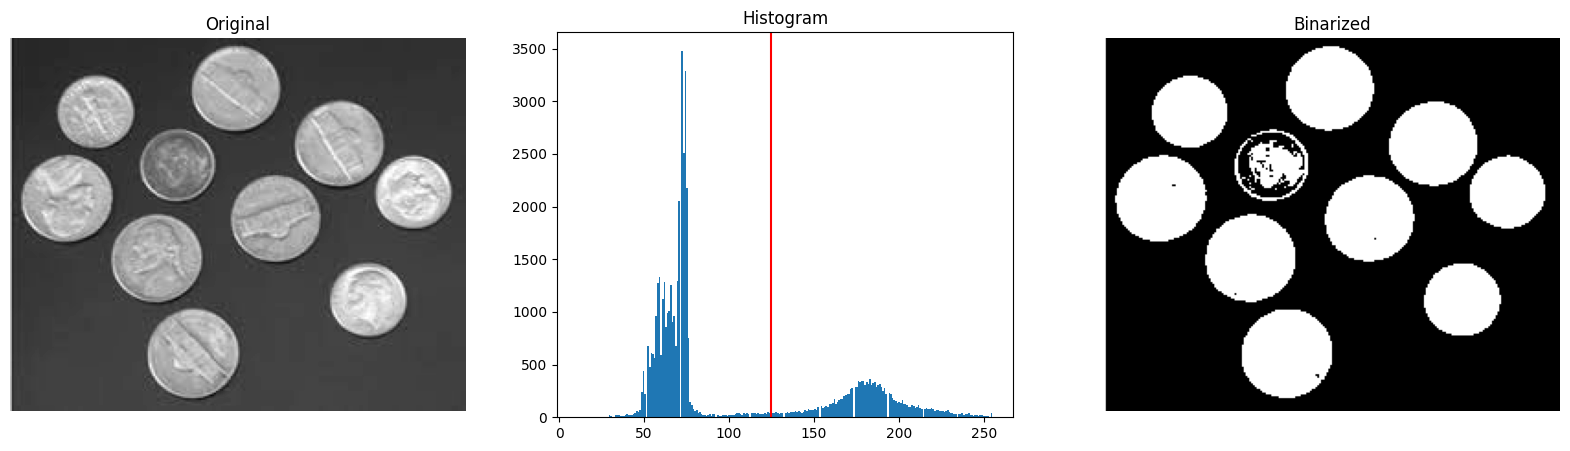

In [60]:
image = coins
thresh = t_between_class
binary = image>thresh

fig, axes = plt.subplots(ncols=3, figsize=(20, 5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Binarized')
ax[2].axis('off')

plt.show()

### **3. Depth based Extraction:**
The image `IIScTextDepth.png` is an inverse depth map of `IIScText.png`.A depth map indicates the depth of an object from the camera for each pixel.Particularly,an inverse depth map has a higher value when the object is nearer to the camera and a lower value when it is farther apart. Binarize the inverse depth map `IIScTextDepth.png` and use that information to extract the text in `IIScText.png` and display it over the background image `IIScMainBuilding.png`.

---

| **Function** | **Image Superimpose**                                        |
|--------------|--------------------------------------------------------------|
| **Input**    | *Text Image, Depth Image, Background Image*                  |
| **Output**   | *An image with the text superimposed on the background image*|

In [61]:
def Image_Superimpose(Text_image,Depth_image,Background_image):

  binary_depth_image = Depth_image>threshold_otsu(Depth_image)                  # Binarize the Depth Image

  superimposed_image = np.copy(Background_image)

  for i in range(len(Text_image)):
    for j in range(len(Text_image[i])):
      if binary_depth_image[i][j]==1:
        superimposed_image[i][j] = Text_image[i][j]                             # Replace appropriate pixels from Text_Image to Background_Image

  return superimposed_image

In [62]:
#Demo Code
time_initial = time.time()
IISc_superimposed = Image_Superimpose(IIScText,IIScTextDepth,IIScMainBuilding)
print('Time required for computation is ' + str(round(time.time()-time_initial,3)) + 's')

Time required for computation is 0.55s


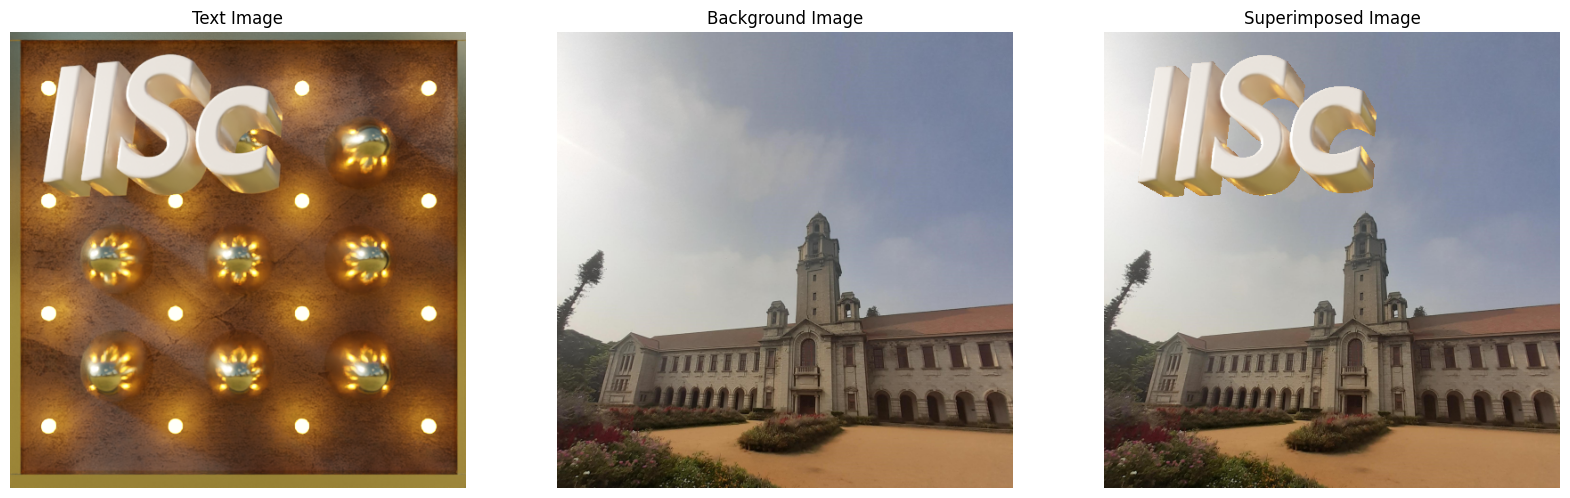

In [63]:
# Result Cell

fig, axes = plt.subplots(ncols=3,figsize = (20,10))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3)

ax[0].imshow(IIScText)
ax[0].set_title('Text Image')
ax[0].axis('off')

ax[1].imshow(IIScMainBuilding)
ax[1].set_title('Background Image')
ax[1].axis('off')

ax[2].imshow(IISc_superimposed)
ax[2].set_title('Superimposed Image')
ax[2].axis('off')

plt.show()

### **4. Connected Components:**
Binarize the image `quote.png` and count the total number of characters
excluding punctuations using connected component analysis.

---

| **Function** | Count characters       |
|--------------|------------------------|
| **Input**    | _Image_                |
| **Output**   | _Number of Characters_ |

In [64]:
def Connected_Components(Image):
  m = len(Image)
  n = len(Image[0])
  R = np.zeros(shape = (m,n),dtype = 'int') #Initialize a zero array of image shape

  counter_table = {}                        #hashtable for creating component counters with indices of connected pixels
  k = 0                                     #Region no. counter

  #Function to invert a binary image
  def invert_binary_image(Img):
    Img = (Img+1)%2
    return Img

  b_image = invert_binary_image(Image>threshold_otsu(Image))      #Binarize and Invert given image

  # Main ALgorithm

  for i in range(m):
    for j in range(n):
      if b_image[i][j]==0:
        pass
      else:
        if (i,j) == (0,0):                           #First Pixel
            k+=1
            R[i][j] = k
            counter_table[k] = k

        elif i-1<0:                                  #First Row
          if b_image[i][j-1] == 1:
            R[i][j] = counter_table[R[i][j-1]]

          else:
            k+=1
            R[i][j] = k
            counter_table[k] = k

        elif j-1<0:                                  #First Column
          if b_image[i-1][j] == 1:
            R[i][j] = counter_table[R[i-1][j]]

          else:
            k+=1
            R[i][j] = k
            counter_table[k] = k

        else:
          if b_image[i][j-1]==0 and b_image[i-1][j]==0:
            k+=1
            R[i][j] = k
            counter_table[k] = k

          elif b_image[i-1][j]==1 and b_image[i][j-1]==0:
            R[i][j] = counter_table[R[i-1][j]]


          elif b_image[i-1][j]==0 and b_image[i][j-1]==1:
            R[i][j] = counter_table[R[i][j-1]]


          elif b_image[i][j-1]==1 and b_image[i-1][j]==1:
            R[i][j] = counter_table[R[i][j-1]]


            if R[i-1][j]!=R[i][j-1]:
              # record that R[i-1][j] and R[i][j-1] are connected.

              counter_table[R[i][j-1]] = min(counter_table[R[i][j-1]],counter_table[R[i-1][j]])
              counter_table[R[i-1][j]] = min(counter_table[R[i][j-1]],counter_table[R[i-1][j]])

  #Helper function to record all connections correctly
  def helper(key):
    if key==counter_table[key]:
      return key
    else:
      return helper(counter_table[key])

  #Loop to record all connections correctly
  for i in range(len(R)):
    for j in range(len(R[i])):
      if R[i][j]!=0:
        R[i][j]=helper(R[i][j])

  #Loop to correct R matrix numbering
  id = 1
  d_id = {}
  for i in range(len(R)):
    for j in range(len(R[i])):
      if R[i][j]!=0:
        if R[i][j] not in d_id.keys():
          d_id[R[i][j]] = id
          id+=1

  for i in range(len(R)):
    for j in range(len(R[i])):
      if R[i][j]!=0:
          R[i][j] = d_id[R[i][j]]

  #Finding number of pixels for each connected component
  no_of_pixels_array = [0 for i in range(len(d_id)+1)]
  g=[]
  for i in range(len(R)):
    for j in range(len(R[i])):
      if R[i][j]!=0:
        no_of_pixels_array[R[i][j]]+=1

  no_of_pixels_array.pop(0)


  # Removing Outliers
  mean = np.mean(no_of_pixels_array)
  std = np.std(no_of_pixels_array)
  count=0
  for i in range(len(no_of_pixels_array)):
    if abs(no_of_pixels_array[i]-mean)/std<2:
      count+=1



  return count,no_of_pixels_array,R

In [65]:
# Demo Code
time_in = time.time()
connected_components = Connected_Components(quote)
time_r = time.time()-time_in
print('Time taken for computation is '+str(round(time_r,3))+'s')

Time taken for computation is 0.941s


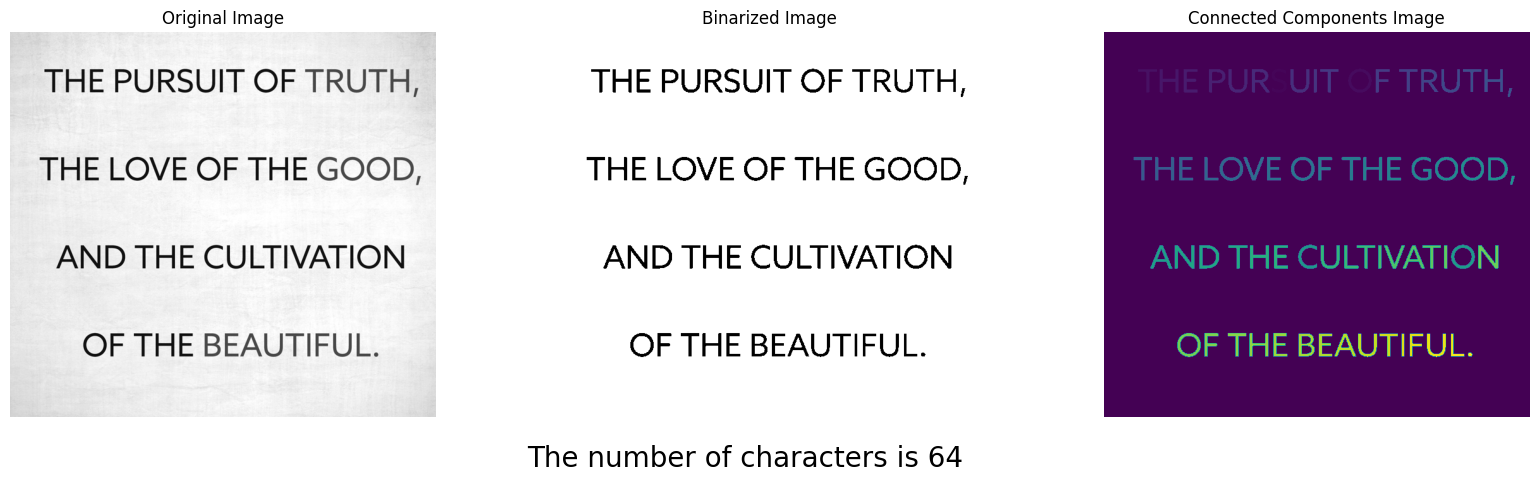

In [66]:
#Result Block

fig, axes = plt.subplots(ncols=3,figsize = (20,5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3)

ax[0].imshow(quote,cmap = 'gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(quote>threshold_otsu(quote),cmap = 'gray')
ax[1].set_title('Binarized Image')
ax[1].axis('off')

ax[2].imshow(connected_components[2])
ax[2].set_title('Connected Components Image')
ax[2].axis('off')

txt = 'The number of characters is ' + str(connected_components[0])
plt.figtext(0.5,0.01,txt, wrap=True, horizontalalignment='center', fontsize=20)

plt.show()

### **5. Optional Bonus Question - MSER:**
Maximally Stable Extremal Regions (MSER) correspond to regions of connected components which, when thresholded around a certain threshold, are stable in terms of the size of the component. Determine the number of characters in `Characters.png` based on MSER using the following steps.:
1. Sweep over all thresholds.
2. For each threshold, determine connected components in the image.
3. A connected component is termed an MSER if the size of the component does not change much (within δ) for a small perturbation ϵ in the choice of the threshold. Note that both δ and ϵ are parameters that need to be chosen.Determine the stable threshold for each connected component.
4. Ignore extremely large or extremely small connected components in the above analysis.

Think about why finding connected components over an Otsu binarized image will not work well in this scenario.

---

| **Function** | **MSER**               |
|--------------|------------------------|
| **Input**    | _Image_                |
| **Output**   | _Number of characters_ |

In [67]:
def Connected_Components_MSER(Image):
  m = len(Image)
  n = len(Image[0])


  counter_table = {}                                                            # Hashtable for creating component counters with indices of connected pixels
  k = 0                                                                         # Region no. counter


  # Cropping Image
  b_image = Image
  crop_i = 0.3
  crop_j = 0.1
  new_image = []
  b_image = b_image[int(m*crop_i):int(m*(1-crop_i))]
  for j in range(len(b_image)):
    new_image.append(b_image[j][int(n*crop_j):int(n*(1-crop_j))])

  b_image = new_image

  R = np.zeros(shape = (len(b_image),len(b_image[0])),dtype = 'int')            # Initialize a zero array (R) of image shape

  # finding majority of white and black pixels
  white = 0
  black = 0
  for i in range(len(b_image)):
    for j in range(len(b_image[i])):
      if b_image[i][j]==1:
        white+=1
      else:
        black+=1

  black = black>white                                                           # Are black pixels more in number

  if black==True:
    color = 1
  else:
    color = 0

  # Main Algorithm

  for i in range(len(b_image)):
    for j in range(len(b_image[i])):
      if b_image[i][j]==1-color:
        pass
      else:
        if (i,j) == (0,0):                                                      # First Pixel
            k+=1
            R[i][j] = k
            counter_table[k] = k

        elif i-1<0:                                                             # First Row
          if b_image[i][j-1] == color :
            R[i][j] = counter_table[R[i][j-1]]

          else:
            k+=1
            R[i][j] = k
            counter_table[k] = k

        elif j-1<0:                                                             # First Column
          if b_image[i-1][j] == color:
            R[i][j] = counter_table[R[i-1][j]]

          else:
            k+=1
            R[i][j] = k
            counter_table[k] = k

        else:                                                                   # Rest of the image
          if b_image[i][j-1]==1-color and b_image[i-1][j]==1-color:
            k+=1
            R[i][j] = k
            counter_table[k] = k

          elif b_image[i-1][j]==color and b_image[i][j-1]==1-color:
            R[i][j] = counter_table[R[i-1][j]]


          elif b_image[i-1][j]==1-color and b_image[i][j-1]==color:
            R[i][j] = counter_table[R[i][j-1]]


          elif b_image[i][j-1]==color and b_image[i-1][j]==color:
            R[i][j] = counter_table[R[i][j-1]]


            if R[i-1][j]!=R[i][j-1]:

              # record that R[i-1][j] and R[i][j-1] are connected.

              counter_table[R[i][j-1]] = min(counter_table[R[i][j-1]],counter_table[R[i-1][j]])
              counter_table[R[i-1][j]] = min(counter_table[R[i][j-1]],counter_table[R[i-1][j]])

  #Helper function to record all connections correctly
  def helper(key):
    if key==counter_table[key]:
      return key
    else:
      return helper(counter_table[key])

  #Loop to record all connections correctly
  for i in range(len(R)):
    for j in range(len(R[i])):
      if R[i][j]!=0:
        R[i][j]=helper(R[i][j])

  #Loop to correct R matrix numbering
  id = 1
  d_id = {}
  for i in range(len(R)):
    for j in range(len(R[i])):
      if R[i][j]!=0:
        if R[i][j] not in d_id.keys():
          d_id[R[i][j]] = id
          id+=1

  for i in range(len(R)):
    for j in range(len(R[i])):
      if R[i][j]!=0:
          R[i][j] = d_id[R[i][j]]

  #Creating list of Region Vectors

  Regions = []                                                                  # Initialising List of all Region Vectors
  Region_hashmap = {}                                                           # Temporary Dict to store Region Vector Info
  for i in range(len(R)):
    for j in range(len(R[i])):
      if R[i][j]!=0:
        if R[i][j] not in Region_hashmap.keys():
          Region_hashmap[R[i][j]] = [i,j,j,j,i,i]
        else:
          max_j = max(Region_hashmap[R[i][j]][2],j)
          min_j = min(Region_hashmap[R[i][j]][3],j)
          max_i = max(Region_hashmap[R[i][j]][4],i)
          min_i = min(Region_hashmap[R[i][j]][5],i)
          Region_hashmap[R[i][j]] = [i,j,max_j,min_j,max_i,min_i]

  for key in Region_hashmap.keys():

    region_width = Region_hashmap[key][2]-Region_hashmap[key][3]                # Width of a region
    region_height = Region_hashmap[key][4] - Region_hashmap[key][5]             # Height of a region
    centre_i = Region_hashmap[key][5] + int(region_height/2)
    centre_j = Region_hashmap[key][3] + int(region_width/2)
    if region_height>50 and region_width>50:                                    # Rejecting small regions
      Regions.append([centre_i,centre_j,region_height,region_width])            # Adding Region Vectors to List

  return Regions,R

In [68]:
def no_of_MSER(Image,delta,epsilon):

  Region_Database = []                                                          # Database for storing all Region Vectors for all thresholds
  Region_Database_count = {}                                                    # Dictionary to store the number of times a Region Vector appears
  tolerance = delta


  for t in range(0,256,5):                                                      # Sweeping over all thresholds (0 - 255) with step 5
    img = Image>t                                                               # Binarizing the image
    regions_t = Connected_Components_MSER(img)[0]                               # Region Vectors corresponding to the binarized image

    if t==0:                                                                    # For the first threshold simply add all region vectors to database
      for i in regions_t:
        Region_Database.append(i)
        Region_Database_count[str(i[:2])] = 1

    else:                                                                       # For the rest of thresholds, compare all new vectors to all old vectors
      for new_vector in regions_t:
        Region_Database_count_initial = Region_Database_count.copy()
        match_found = False

        for old_vector in Region_Database:
          if (np.allclose(new_vector,old_vector,atol = tolerance)):
            Region_Database_count[str(old_vector[:2])] += 5
            match_found = True


        if not match_found:                                                     # Match not Found implies new region has appeared
          Region_Database.append(new_vector)
          Region_Database_count[str(new_vector[:2])] = 1

  count = 0                                                                     # Variable to keep count of number of MSER

  Region_Database_count_list = list(Region_Database_count.values())             # List of all Regions for all thresholds

  for i in Region_Database_count_list:
    if i>epsilon:                          # If Region exists for more than epsilon thresholds then its considered as a MSER
      count+=1

  return count , Region_Database_count_list

In [73]:
time_initial = time.time()
count , Region_Database_count = no_of_MSER(charachters,10,50)
print('Time required for computation is ' + str(round(time.time()-time_initial,3)) + 's')

Time required for computation is 135.866s


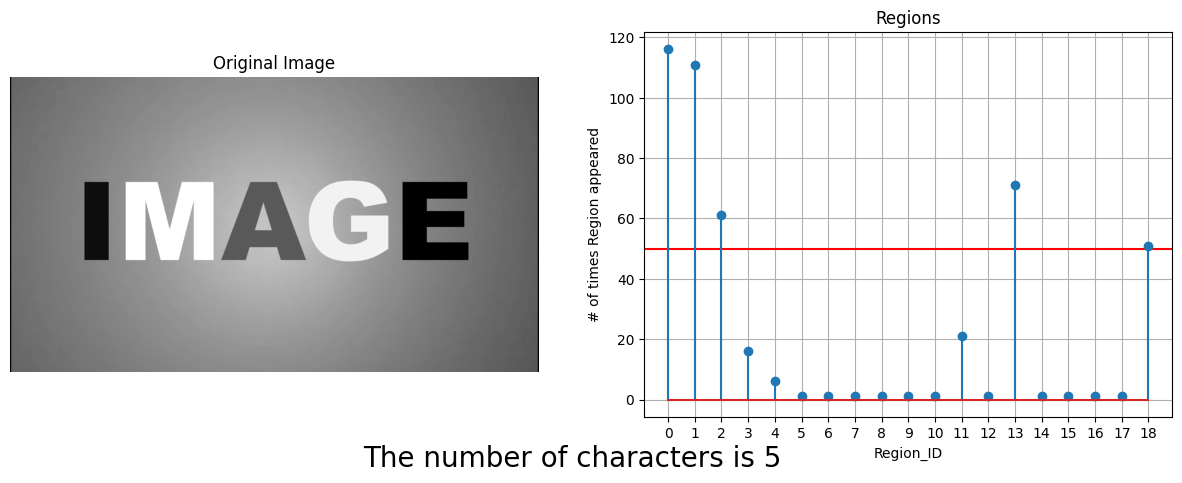

In [82]:
# Result Cell

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 2, 1)
ax[1] = plt.subplot(1, 2, 2)

ax[0].imshow(charachters, cmap=plt.cm.gray)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].axhline(50, color='r')
ax[1].stem(Region_Database_count)
ax[1].set_title('Regions')
ax[1].set_xlabel('Region_ID')
ax[1].set_ylabel('# of times Region appeared')
ax[1].grid()
ax[1].set_xticks(range(len(Region_Database_count)))


txt = 'The number of characters is ' + str(count)
plt.figtext(0.5,0.01,txt, wrap=True, horizontalalignment='center', fontsize=20)

plt.show()